In [3]:
import numpy as np
import matplotlib.pyplot as plt
#Plot the animation
from matplotlib.animation import FuncAnimation
pos=np.load('data_npy/100_2.npy')
vid=np.load('data_video/100_2.npy')
midline=np.load('data_midline/100_2_consistent.npy')
velocity =midline[1:,:,1,:]-midline[:-1,:,1,:]
head=midline[:,:,0,:]-midline[:,:,1,:]
tail=midline[:,:,2,:]-midline[:,:,1,:]
def angle_between_2vec(vec1, vec2, axis=2):
    """Calculate the angle between two vectors."""
    return np.arctan2(
        np.cross(vec1, vec2, axis=axis),
        np.sum(vec1 * vec2, axis=axis)
    )
theta=angle_between_2vec(head, tail, axis=2)
phi= np.arctan2(head[:,:,1], head[:,:,0])
angular_speed= angle_between_2vec(head[1:,:,:], head[:-1,:,:], axis=2) 
L1=np.linalg.norm(head, axis=2)
L2=np.linalg.norm(tail, axis=2)
Observer_index=0
R=500
Observed_vector=midline[:,None,:,1,:]-midline[:,:,None,1,:]
Observed_distance=np.linalg.norm(Observed_vector, axis=3)
Observed_phi=angle_between_2vec(head[:,:,None,:], Observed_vector, axis=3)
Observed_index=Observed_distance<=R

In [5]:
center=np.array([vid.shape[1]/2, vid.shape[0]/2])
Radius=np.max(center)-np.linalg.norm(pos-center[None,None,:], axis=2)
Time=pos.shape[0]
Radius[Radius>R]=-1
speed=np.linalg.norm(velocity, axis=2)
velocity_phi= angle_between_2vec(head[:-1], velocity, axis=2)

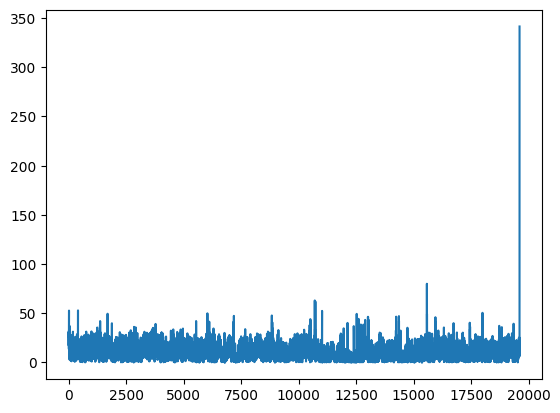

In [7]:
plt.plot(speed[:,0])

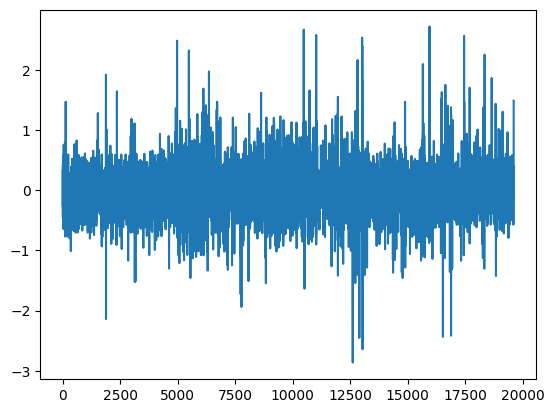

In [10]:
plt.plot(angular_speed[:,0])

In [ ]:
plt.plot(angular_speed[:,0])

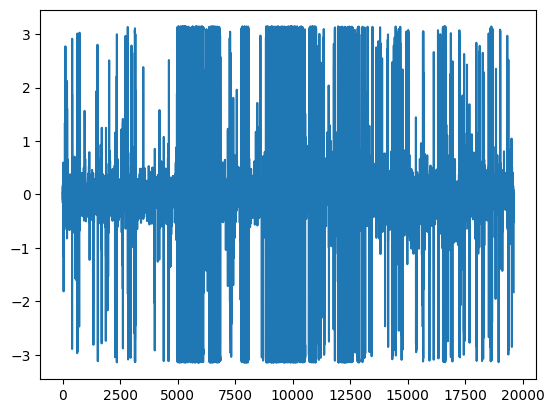

In [6]:
plt.plot(velocity_phi[:,0])

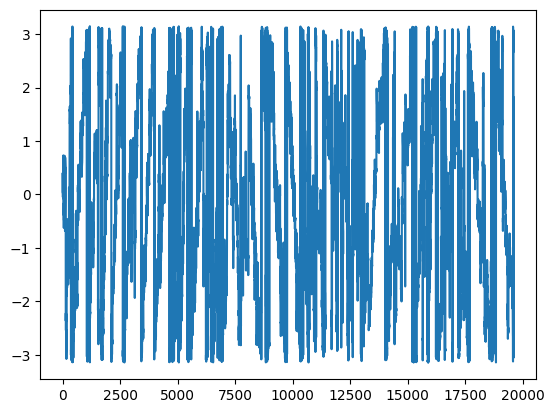

In [11]:
plt.plot(phi[:,0])

In [19]:
import torch
from torch import nn
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x
class DeepSet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DeepSet, self).__init__()
        self.encoder = Encoder(input_dim-1, hidden_dim, input_dim-1)
        self.decoder = Decoder(input_dim, hidden_dim, output_dim)

    def forward(self, x, Observed_index):
        N_obs=[]
        for Observer_index in range(100):
            inputs=[]
            inputs.append(x[0][Observer_index,Observed_index[Observer_index]])
            inputs.append(x[1][Observer_index,Observed_index[Observer_index]])
            inputs.append(x[2][Observed_index[Observer_index]])
            inputs.append(x[3][Observed_index[Observer_index]]-x[3][Observer_index])
            inputs= torch.from_numpy(np.array(inputs)).T
            x2 = self.encoder(torch.from_numpy(np.array(inputs)))
            x2 = torch.mean(x2, dim=0)  # Aggregation
            x2=torch.concat((x2,torch.tensor([x[4][Observer_index]])))
            N_obs.append(x2)
        x = self.decoder(torch.stack(N_obs).float())
        return x
model= DeepSet(input_dim=5, hidden_dim=8, output_dim=4)


In [ ]:
from tqdm import tqdm
num_epoch=20
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
losses=[]
for epoch in range(num_epoch):
    for t in tqdm(range(Time-1)):
        model.train()
        optimizer.zero_grad()
        inputs =[]
        inputs.append(Observed_distance[t])
        inputs.append(Observed_phi[t])
        inputs.append(theta[t])
        inputs.append(phi[t])
        inputs.append(Radius[t])

        truth=[]
        truth.append(speed[t])
        truth.append(velocity_phi[t])
        truth.append(angular_speed[t])
        truth.append(theta[t+1])
        outputs = model(inputs, Observed_index[t])
        loss = loss_fn(outputs, torch.from_numpy(np.array(truth).T).float())
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epoch}, Loss: {loss.item():.4f}')

100%|██████████| 19611/19611 [03:22<00:00, 96.70it/s] 


Epoch 1/20, Loss: 465257.0000


100%|██████████| 19611/19611 [12:35:58<00:00,  2.31s/it]      


Epoch 2/20, Loss: 465233.7500


 19%|█▉        | 3805/19611 [00:59<07:27, 35.33it/s]